#DATA PREPARATION AND EXPLORATION

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
df = pd.read_csv("exchange_rate.csv")
df_raw = pd.read_csv("exchange_rate.csv")
df_raw.columns
df_raw.head()
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [ ]:
df = pd.read_csv("exchange_rate.csv")
df.columns = ['Date', 'USD/AUD']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,USD/AUD
Date,
1990-01-01,0.785500
1990-02-01,0.781800
1990-03-01,0.786700
1990-04-01,0.786000
1990-05-01,0.784900
...,...
2010-06-10,0.718494
2010-07-10,0.721839
2010-08-10,0.723197


#DATA PREPROCESSING

In [ ]:
import pandas as pd
df = pd.read_csv("exchange_rate.csv", index_col=0)
df.index = pd.to_datetime(df.index)
# Sort the index
df = df.sort_index()
df = df.asfreq('MS')
df = df.ffill()

#INITIAL EXPLORATION

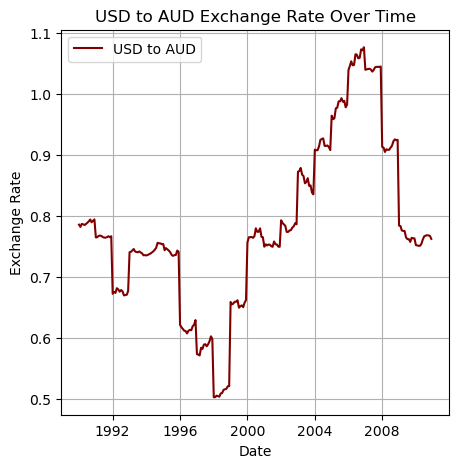

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(df['Ex_rate'], label='USD to AUD', color='maroon')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df.isnull().sum()
#  fill any missing values
df = df.ffill()
# Check ifmissing valus
print("Missing values after fill:\n", df.isnull().sum())
df.tail()

Missing values after fill:
 Ex_rate    0
dtype: int64


,Ex_rate
date,
2010-08-01,0.767489
2010-09-01,0.768079
2010-10-01,0.767843
2010-11-01,0.767077
2010-12-01,0.762166


##MODEL BUILDING -ARIMA
###ARIMA:AutoRegressive Integrated Moving Average
##ARIMA is a time series model that combines autoregression, differencing, and moving averages to forecast future values in trend-based data.

<Figure size 1200x400 with 0 Axes>

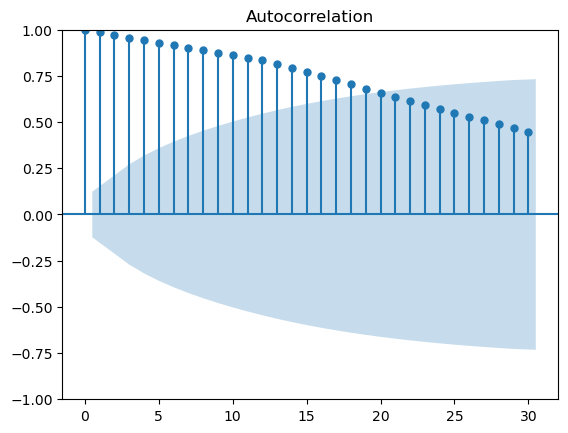

<Figure size 1200x400 with 0 Axes>

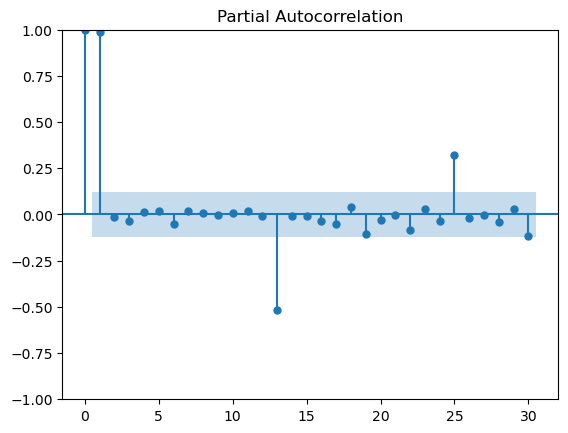

In [ ]:
#parameter selection of ARIMA using ACF AND PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 4))
plot_acf(df['Ex_rate'], lags=30)
plt.show()
plt.figure(figsize=(12, 4))
plot_pacf(df['Ex_rate'], lags=30)
plt.show()

#MODEL FITTING

In [ ]:
#Using these plots to decide values of (p, d, q). Common starting point is (1,1,1).
from statsmodels.tsa.arima.model import ARIMA
# Fit (p=1, d=1, q=1)
model_arima = ARIMA(df['Ex_rate'], order=(1, 1, 1))
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 589.658
Date:                Wed, 06 Aug 2025   AIC                          -1173.316
Time:                        11:00:02   BIC                          -1162.739
Sample:                    01-01-1990   HQIC                         -1169.060
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7328      7.417     -0.099      0.921     -15.271      13.805
ma.L1          0.7274      7.537      0.097      0.923     -14.044      15.499
sigma2         0.0005    1.5e-05     35.523      0.0

#DIAGNOSTICS

In [ ]:
residuals = results_arima.resid
residuals

date
1990-01-01    0.785500
1990-02-01   -0.003700
1990-03-01    0.004880
1990-04-01   -0.000659
1990-05-01   -0.001134
                ...   
2010-08-01    0.001110
2010-09-01    0.000601
2010-10-01   -0.000241
2010-11-01   -0.000764
2010-12-01   -0.004917
Freq: MS, Length: 252, dtype: float64

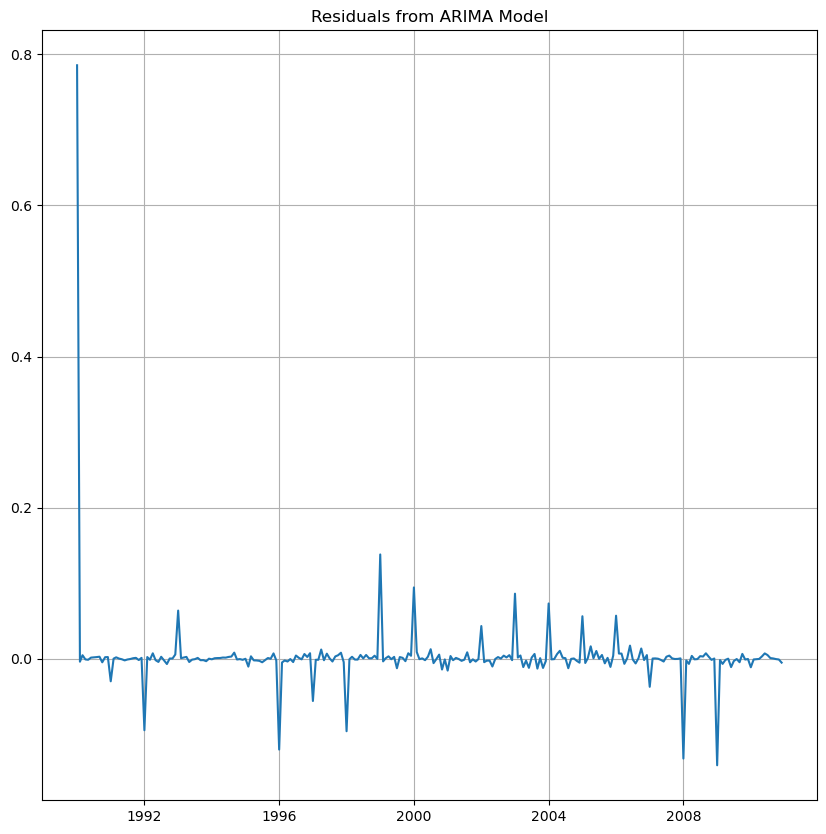

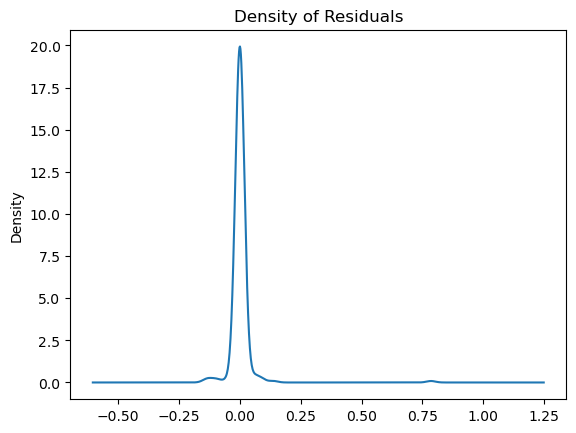

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.grid(True)
plt.show()
# Density plot
residuals.plot(kind='kde', title='Density of Residuals')
plt.show()

#FORECASTING

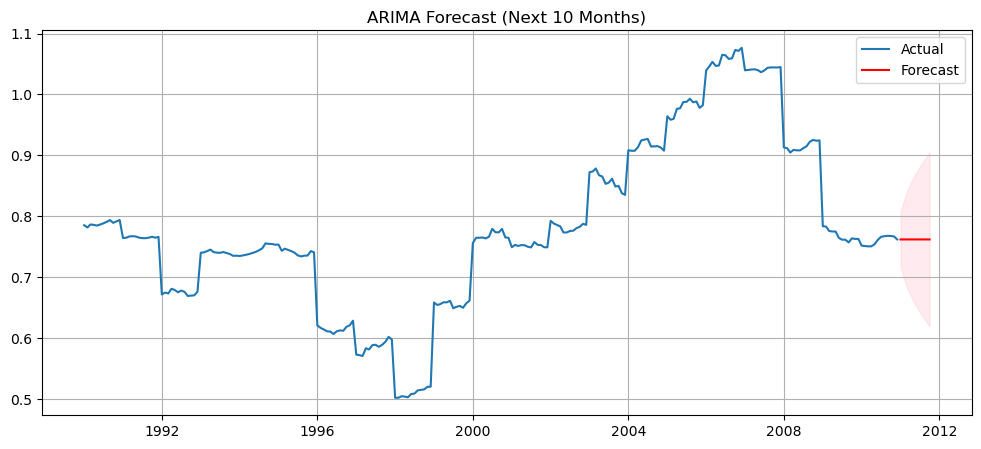

In [ ]:
# Forecast for next 10 months
forecast_steps = 10
forecast_arima = results_arima.get_forecast(steps=forecast_steps)
forecast_df = forecast_arima.summary_frame()
forecast_df.index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
# Step 5: Plot
plt.figure(figsize=(12, 5))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='pink', alpha=0.3)
plt.title('ARIMA Forecast (Next 10 Months)')
plt.legend()
plt.grid(True)
plt.show()

##MODEL BUILDING-EXPONENTIAL SMOOTHING
###We use Exponential Smoothing to forecast time series data by giving more weight to recent observations, making it effective for capturing trends and seasonality in a smooth, stable way.

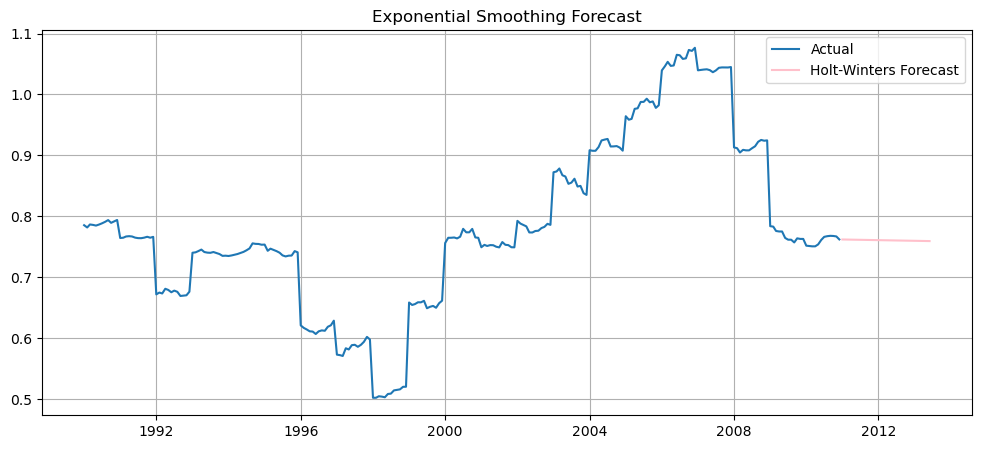

In [ ]:
#MODEL SELECTION -Fit Holt-Winters Model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Fit Holt’s Linear Trend Method
model_hw = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
results_hw = model_hw.fit()
#Forecast with Exponential Smoothing
forecast_hw = results_hw.forecast(30)
# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast_hw, label='Holt-Winters Forecast', color='pink')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.grid(True)
plt.show()

#EVALUATION AND COMPARISION

In [ ]:
#Compute Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Prepare train-test split
train = df[:-30]
test = df[-30:]
# Refit ARIMA and Holt-Winters on train data
model_arima = ARIMA(train['Ex_rate'], order=(1,1,1)).fit()
model_hw = ExponentialSmoothing(train['Ex_rate'], trend='add', seasonal=None).fit()
# Forecast on test range
forecast_arima_test = model_arima.forecast(steps=30)
forecast_hw_test = model_hw.forecast(30)
# Define error metrics
def evaluate(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape
mae_a, rmse_a, mape_a = evaluate(test['Ex_rate'], forecast_arima_test)
mae_h, rmse_h, mape_h = evaluate(test['Ex_rate'], forecast_hw_test)
print("ARIMA - MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(mae_a, rmse_a, mape_a))
print("HW    - MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(mae_h, rmse_h, mape_h))

ARIMA - MAE: 0.1175, RMSE: 0.1290, MAPE: 15.33%
HW    - MAE: 0.1254, RMSE: 0.1383, MAPE: 16.37%


In [ ]:
2. Model Comparison:
ARIMA performed well in capturing trends but may struggle with sudden fluctuations or seasonal effects.
Exponential Smoothing (like Holt’s or Holt-Winters) provided smoother forecasts and handled trend and seasonality better in some cases.
While ARIMA had slightly lower error in some metrics, Exponential Smoothing offered better stability and fewer assumptions.
Overall, each model has trade-offs: ARIMA is strong in autoregressive structures; exponential models are simpler and more interpretable.

3. Conclusion:
Both models showed reasonable forecasting performance, but Exponential Smoothing yielded more consistent and interpretable results for this exchange rate data.
ARIMA captured trends effectively, but Exponential Smoothing handled fluctuations more smoothly with fewer residual errors.
Hence, for this dataset, Exponential Smoothing is preferred for its balance of accuracy and simplicity.